<a href="https://colab.research.google.com/github/bmedinam-prog/Se-ales-y-Sistemas/blob/main/10scancion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pytube falla o no está disponible: No module named 'pytube'
Intentando descargar con yt-dlp...
RUN: yt-dlp -f bestaudio -o /tmp/tmpd8ivex37/audio.%(ext)s https://youtu.be/AmNOfqeUFLk?si=hV4JHxtIITCj7iyh
yt-dlp falla o no está disponible: [Errno 2] No such file or directory: 'yt-dlp'
Ocurrió un error en main(): No se pudo descargar audio: instala pytube o yt-dlp o activa TEST_MODE
Ejecutando modo de prueba automático (señal sintética).
TEST_MODE activo — se genera señal sintética (sin descargar).
Aplicando: Butterworth (order=4)
Aplicando: Cheby I (order=4, rp=1.0dB)
Aplicando: Cheby II (order=6, rs=40.0dB)
Aplicando: Bessel (order=5)
Aplicando: Ellip (order=6, rp=1.0dB, rs=60.0dB)
Aplicando: FIR firwin (numtaps=513)


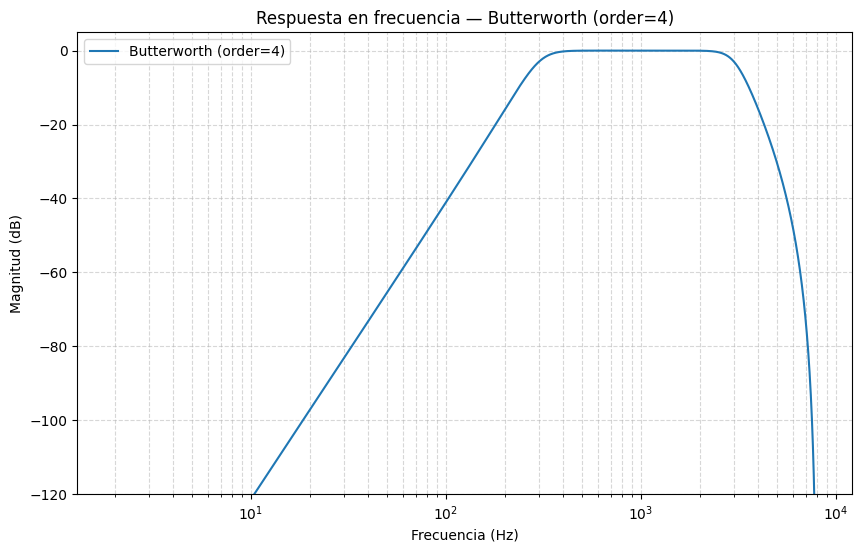

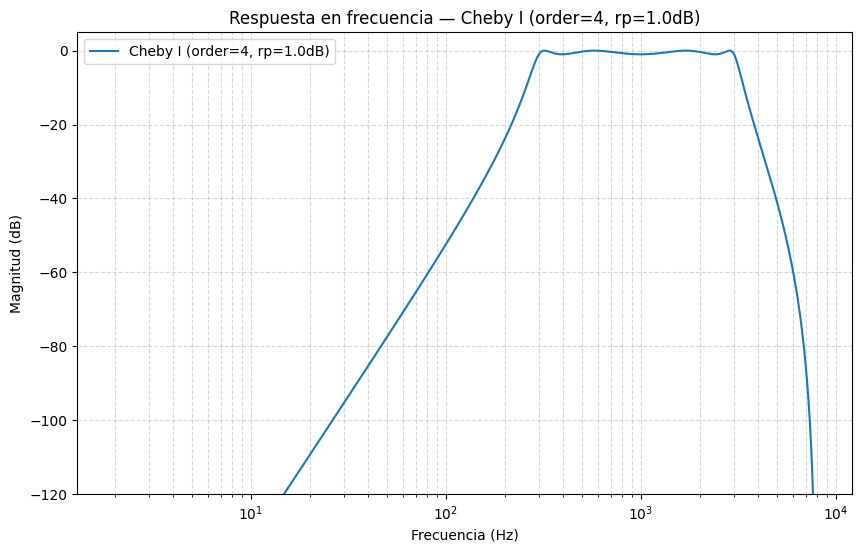

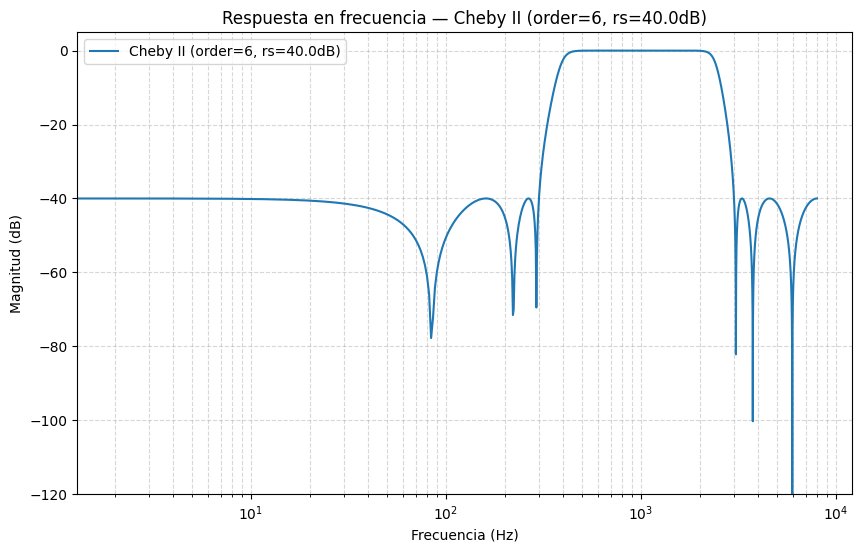

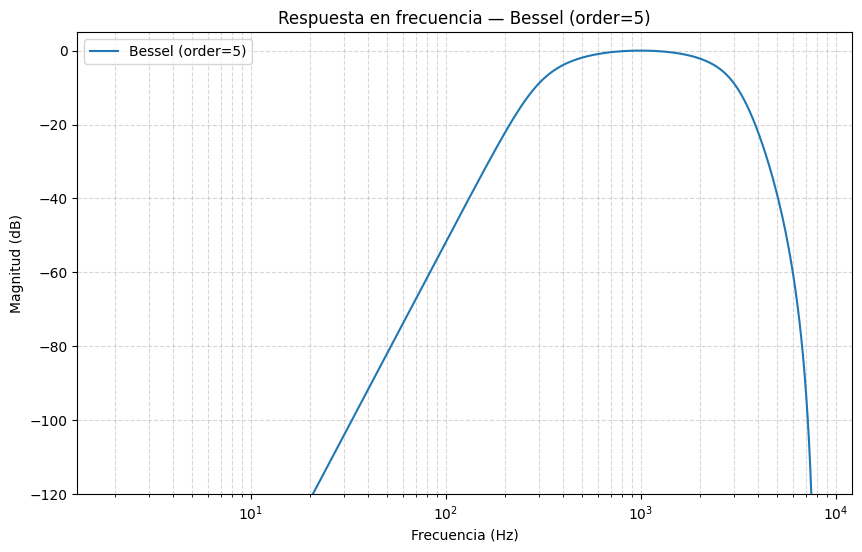

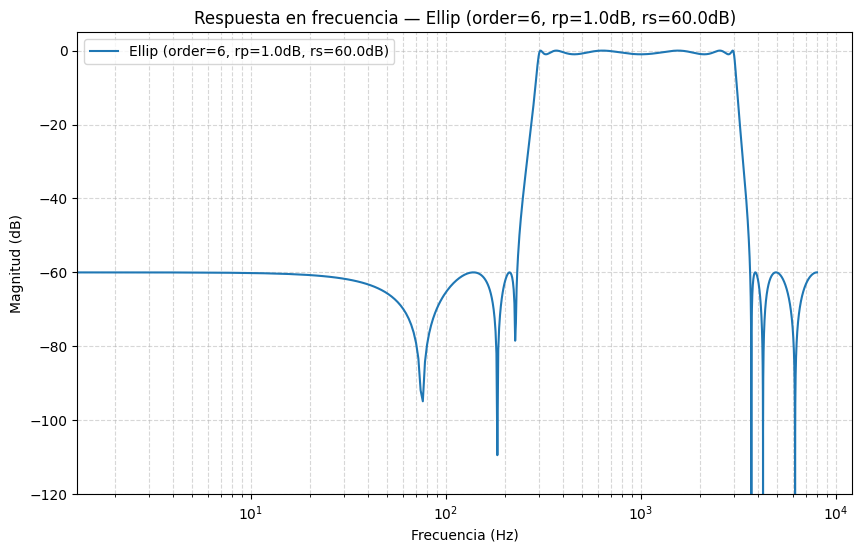

/tmp/ipython-input-1104282110.py:191: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


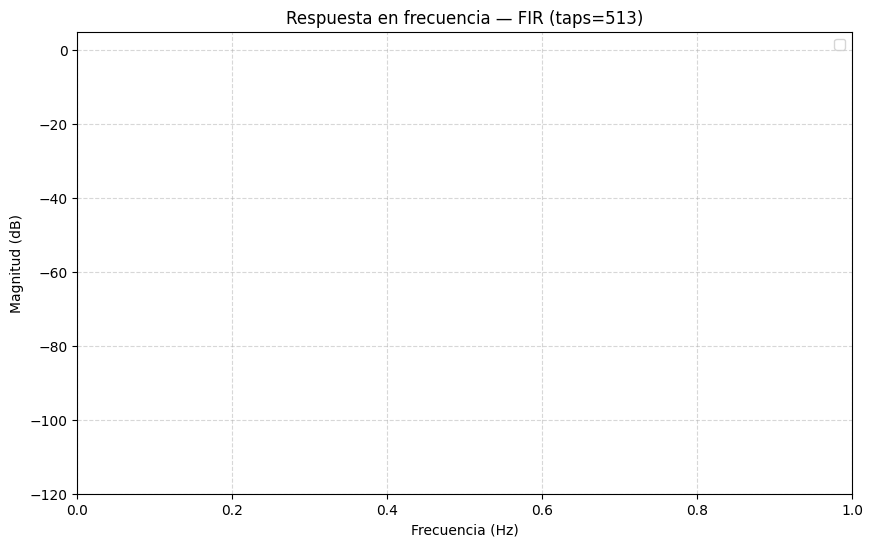

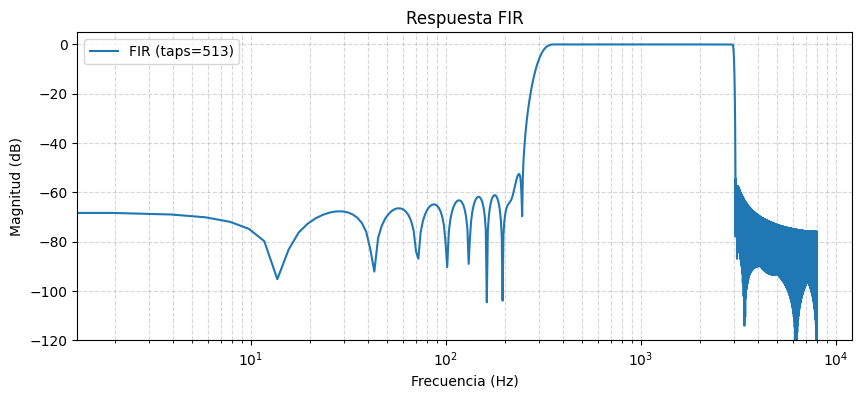

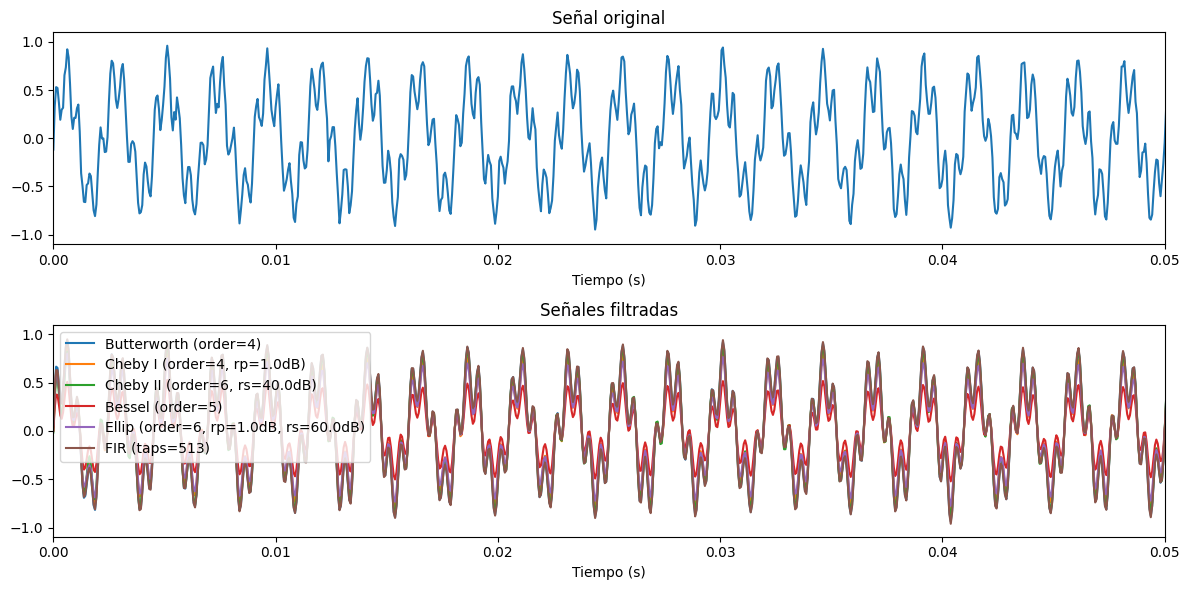


Métricas simples:
Butterworth (order=4): pico=0.0 dB, att_10Hz=-122.2 dB, att_fs/2-10=-234.6 dB
Cheby I (order=4, rp=1.0dB): pico=-0.0 dB, att_10Hz=-134.4 dB, att_fs/2-10=-240.0 dB
Cheby II (order=6, rs=40.0dB): pico=0.0 dB, att_10Hz=-40.1 dB, att_fs/2-10=-40.0 dB
Bessel (order=5): pico=-0.0 dB, att_10Hz=-152.8 dB, att_fs/2-10=-240.0 dB
Ellip (order=6, rp=1.0dB, rs=60.0dB): pico=-0.0 dB, att_10Hz=-60.2 dB, att_fs/2-10=-60.0 dB
FIR (taps=513): pico=0.0 dB, att_10Hz=-74.8 dB, att_fs/2-10=-81.1 dB

Archivos guardados en: /content/outputs_filters


In [3]:


import os
import subprocess
import tempfile
import shutil
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

# ----------------------------- CONFIGURACIÓN USUARIO -----------------------------
YOUTUBE_URL = "https://youtu.be/AmNOfqeUFLk?si=hV4JHxtIITCj7iyh"
START = 0        # segundos de inicio del segmento
DURATION = 10    # segundos a extraer
FS_TARGET = 16000  # frecuencia de muestreo objetivo (Hz) para el WAV
OUT_DIR = "outputs_filters"  # carpeta donde se guardan los WAV
TEST_MODE = False  # si True no descarga YouTube; genera señal sintética

# Banda pasabanda (usuario puede cambiar)
f_low = 300.0
f_high = 3000.0

# Parámetros de filtros
butter_order = 4
cheby1_order = 4
cheby1_ripple = 1.0
cheby2_order = 6
cheby2_atten = 40.0
bessel_order = 5
ellip_order = 6
ellip_ripple = 1.0
ellip_atten = 60.0

# FIR
fir_numtaps = 513

# ----------------------------- UTILIDADES -----------------------------

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)


def run_cmd(cmd):
    # Ejecuta un comando y lanza error si falla, imprime salida breve
    print('RUN:', ' '.join(cmd))
    res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if res.returncode != 0:
        print('ERROR running command:', res.stderr.strip())
        raise RuntimeError(f"Command failed: {' '.join(cmd)}")
    return res.stdout


# ----------------------------- DESCARGA Y CONVERSIÓN -----------------------------

def download_audio_from_youtube(url, outdir=None):
    """Intenta descargar el stream de audio desde YouTube y devuelve la ruta del archivo descargado.
    Primero intenta pytube; si no está disponible o falla, intenta yt-dlp (si existe).
    """
    outdir = outdir or tempfile.mkdtemp()
    ensure_dir(outdir)
    outpath = None
    # Try pytube
    try:
        from pytube import YouTube
        print('Descargando con pytube...')
        yt = YouTube(url)
        stream = yt.streams.filter(only_audio=True).order_by('abr').desc().first()
        if stream is None:
            raise RuntimeError('No se encontró stream de audio con pytube')
        fn = stream.default_filename
        downloaded = os.path.join(outdir, fn)
        stream.download(output_path=outdir)
        outpath = downloaded
        print('Descarga completada (pytube):', outpath)
        return outpath
    except Exception as e:
        print('pytube falla o no está disponible:', str(e))
    # Try yt-dlp if pytube failed
    try:
        print('Intentando descargar con yt-dlp...')
        template = os.path.join(outdir, 'audio.%(ext)s')
        cmd = ['yt-dlp', '-f', 'bestaudio', '-o', template, url]
        run_cmd(cmd)
        for f in os.listdir(outdir):
            if f.startswith('audio.'):
                outpath = os.path.join(outdir, f)
                break
        if outpath is None:
            raise RuntimeError('yt-dlp no produjo un archivo esperado')
        print('Descarga completada (yt-dlp):', outpath)
        return outpath
    except Exception as e:
        print('yt-dlp falla o no está disponible:', str(e))
        raise RuntimeError('No se pudo descargar audio: instala pytube o yt-dlp o activa TEST_MODE')


def convert_to_wav(src_path, dst_path, fs_target=FS_TARGET):
    """Convierte cualquier archivo de audio a WAV mono con la frecuencia fs_target usando ffmpeg."""
    dst_dir = os.path.dirname(dst_path)
    ensure_dir(dst_dir)
    cmd = [
        'ffmpeg', '-y', '-i', src_path,
        '-ac', '1', '-ar', str(fs_target), dst_path
    ]
    run_cmd(cmd)
    return dst_path


# ----------------------------- CARGA DE AUDIO (sin soundfile ni librosa) -----------------------------

def load_wav_segment(wav_path, start=0.0, duration=10.0):
    """Carga un WAV con scipy.io.wavfile, normaliza a float32 en [-1,1] y extrae el segmento.
    Devuelve (segment_float32, sr).
    """
    sr, data = wavfile.read(wav_path)
    # Convertir a float32 en rango [-1,1]
    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32768.0
    elif data.dtype == np.int32:
        data = data.astype(np.float32) / 2147483648.0
    elif data.dtype == np.uint8:
        data = (data.astype(np.float32) - 128) / 128.0
    else:
        data = data.astype(np.float32)
    # stereo -> mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)
    start_sample = int(start * sr)
    end_sample = start_sample + int(duration * sr)
    start_sample = max(0, start_sample)
    end_sample = min(len(data), end_sample)
    segment = data[start_sample:end_sample]
    return segment, sr


def write_wav_float(path, data_float, sr):
    """Escribe WAV usando scipy.io.wavfile, escalando float en [-1,1] a int16.
    """
    # clip
    clipped = np.clip(data_float, -1.0, 1.0)
    int16 = np.int16(clipped * 32767)
    wavfile.write(path, sr, int16)


# ----------------------------- DISEÑO DE FILTROS (uso de SOS) -----------------------------

def design_band_sos(kind, order, sr, lowcut, highcut, **kwargs):
    nyq = sr / 2.0
    wp = [lowcut / nyq, highcut / nyq]
    if any(f <= 0 or f >= 1 for f in wp):
        raise ValueError('Frecuencias normalizadas fuera de rango (0,1). Verifica lowcut/highcut y sr.')
    if kind == 'butter':
        sos = signal.butter(order, wp, btype='band', output='sos')
    elif kind == 'cheby1':
        rp = kwargs.get('rp', 1.0)
        sos = signal.cheby1(order, rp, wp, btype='band', output='sos')
    elif kind == 'cheby2':
        rs = kwargs.get('rs', 40.0)
        sos = signal.cheby2(order, rs, wp, btype='band', output='sos')
    elif kind == 'ellip':
        rp = kwargs.get('rp', 1.0)
        rs = kwargs.get('rs', 60.0)
        sos = signal.ellip(order, rp, rs, wp, btype='band', output='sos')
    elif kind == 'bessel':
        sos = signal.bessel(order, wp, btype='band', output='sos', norm='phase')
    else:
        raise ValueError('Tipo de filtro desconocido')
    return sos


def apply_sosfiltfilt(sos, x):
    # use sosfiltfilt for zero-phase; si falla, usar sosfilt
    try:
        y = signal.sosfiltfilt(sos, x)
    except Exception:
        y = signal.sosfilt(sos, x)
    return y


# ----------------------------- VISUALIZACIÓN -----------------------------

def plot_frequency_responses(responses, sr):
    for label, sos in responses:
        plt.figure(figsize=(10, 6))
        if sos is not None:
            w, h = signal.sosfreqz(sos, worN=4096, fs=sr)
            plt.semilogx(w, 20 * np.log10(np.maximum(np.abs(h), 1e-12)), label=label)
        plt.title(f'Respuesta en frecuencia — {label}')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud (dB)')
        plt.grid(which='both', linestyle='--', alpha=0.5)
        plt.legend()
        plt.ylim([-120, 5])
        plt.show()


def plot_time_domain(original, filtered_dict, sr, zoom=None):
    t = np.arange(len(original))/sr
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.plot(t, original)
    plt.title('Señal original')
    plt.xlabel('Tiempo (s)')
    if zoom:
        plt.xlim(zoom)
    plt.subplot(2,1,2)
    for label, sig in filtered_dict.items():
        plt.plot(t[:len(sig)], sig, label=label)
    plt.title('Señales filtradas')
    plt.xlabel('Tiempo (s)')
    if zoom:
        plt.xlim(zoom)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ----------------------------- MAIN PIPELINE -----------------------------

def main(youtube_url=YOUTUBE_URL, start=START, duration=DURATION, fs_target=FS_TARGET, out_dir=OUT_DIR, test_mode=TEST_MODE):
    ensure_dir(out_dir)
    tmpdir = tempfile.mkdtemp()
    try:
        if test_mode:
            print('TEST_MODE activo — se genera señal sintética (sin descargar).')
            sr = fs_target
            t = np.linspace(0, duration, int(sr*duration), endpoint=False)
            sig = 0.6*np.sin(2*np.pi*440*t) + 0.3*np.sin(2*np.pi*2000*t) + 0.05*np.random.randn(len(t))
            seg = sig.astype(np.float32)
            write_wav_float(os.path.join(out_dir, 'segmento_sintetico.wav'), seg, sr)
        else:
            src_audio = download_audio_from_youtube(youtube_url, outdir=tmpdir)
            wav_path = os.path.join(tmpdir, 'audio_converted.wav')
            convert_to_wav(src_audio, wav_path, fs_target)
            seg, sr = load_wav_segment(wav_path, start=start, duration=duration)
            write_wav_float(os.path.join(out_dir, 'segmento_10s.wav'), seg, sr)
            print(f'Segmento guardado en {out_dir}/segmento_10s.wav (sr={sr})')

        if test_mode:
            seg, sr = load_wav_segment(os.path.join(out_dir, 'segmento_sintetico.wav'), start=0, duration=duration)

        # 4) Diseñar filtros
        designs = []
        sos_butter = design_band_sos('butter', butter_order, sr, f_low, f_high)
        designs.append((f'Butterworth (order={butter_order})', sos_butter))
        sos_cheb1 = design_band_sos('cheby1', cheby1_order, sr, f_low, f_high, rp=cheby1_ripple)
        designs.append((f'Cheby I (order={cheby1_order}, rp={cheby1_ripple}dB)', sos_cheb1))
        sos_cheb2 = design_band_sos('cheby2', cheby2_order, sr, f_low, f_high, rs=cheby2_atten)
        designs.append((f'Cheby II (order={cheby2_order}, rs={cheby2_atten}dB)', sos_cheb2))
        sos_bessel = design_band_sos('bessel', bessel_order, sr, f_low, f_high)
        designs.append((f'Bessel (order={bessel_order})', sos_bessel))
        sos_ellip = design_band_sos('ellip', ellip_order, sr, f_low, f_high, rp=ellip_ripple, rs=ellip_atten)
        designs.append((f'Ellip (order={ellip_order}, rp={ellip_ripple}dB, rs={ellip_atten}dB)', sos_ellip))

        # FIR
        nyq = sr/2.0
        taps = signal.firwin(fir_numtaps, [f_low/nyq, f_high/nyq], pass_zero=False)

        # 5) Aplicar filtros y guardar
        filtered = {}
        for label, sos in designs:
            print('Aplicando:', label)
            y = apply_sosfiltfilt(sos, seg)
            filtered[label] = y
            out_name = f"{label.replace(' ','_').replace('(','').replace(')','').replace(',','')}.wav"
            write_wav_float(os.path.join(out_dir, out_name), y, sr)

        print('Aplicando: FIR firwin (numtaps=%d)'%fir_numtaps)
        y_fir = signal.filtfilt(taps, [1.0], seg)
        filtered[f'FIR (taps={fir_numtaps})'] = y_fir
        write_wav_float(os.path.join(out_dir, f'fir_{fir_numtaps}.wav'), y_fir, sr)

        # 6) Plots
        plot_frequency_responses(designs + [(f'FIR (taps={fir_numtaps})', None)], sr)
        plt.figure(figsize=(10,4))
        w_f, h_f = signal.freqz(taps, worN=4096, fs=sr)
        plt.semilogx(w_f, 20*np.log10(np.maximum(np.abs(h_f), 1e-12)), label=f'FIR (taps={fir_numtaps})')
        plt.title('Respuesta FIR')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud (dB)')
        plt.grid(which='both', linestyle='--', alpha=0.5)
        plt.legend()
        plt.ylim([-120, 5])
        plt.show()

        plot_time_domain(seg, filtered, sr, zoom=(0, 0.05))

        # 7) Métricas sencillas
        print('\nMétricas simples:')
        for label, sos in designs:
            w, h = signal.sosfreqz(sos, worN=4096, fs=sr)
            mag = 20*np.log10(np.maximum(np.abs(h), 1e-12))
            idx_low = np.argmin(np.abs(w - 10.0))
            idx_high = np.argmin(np.abs(w - (sr/2.0 - 10.0)))
            print(f"{label}: pico={np.max(mag):.1f} dB, att_10Hz={mag[idx_low]:.1f} dB, att_fs/2-10={mag[idx_high]:.1f} dB")
        w, h = signal.freqz(taps, worN=4096, fs=sr)
        mag = 20*np.log10(np.maximum(np.abs(h), 1e-12))
        idx_low = np.argmin(np.abs(w - 10.0))
        idx_high = np.argmin(np.abs(w - (sr/2.0 - 10.0)))
        print(f"FIR (taps={fir_numtaps}): pico={np.max(mag):.1f} dB, att_10Hz={mag[idx_low]:.1f} dB, att_fs/2-10={mag[idx_high]:.1f} dB")

        print(f"\nArchivos guardados en: {os.path.abspath(out_dir)}")

    finally:
        try:
            shutil.rmtree(tmpdir)
        except Exception:
            pass


# ----------------------------- EJECUCIÓN / TESTS -----------------------------
if __name__ == '__main__':
    # Si se desea probar sin descargar (por ejemplo en entornos sin pytube/yt-dlp), activar TEST_MODE=True
    try:
        main(test_mode=TEST_MODE)
    except Exception as e:
        print('Ocurrió un error en main():', str(e))
        print('Ejecutando modo de prueba automático (señal sintética).')
        main(test_mode=True)

# ----------------------------- NOTAS -----------------------------
# 1) Si quieres que ajuste los parámetros de los filtros (órdenes, ripples), dímelo y lo monto con
#    widgets interactivos (ipywidgets) para experimentar en tiempo real.
# 2) Pregunta: ¿Deseas que el script exporte además un CSV con las métricas de cada filtro? Si no, lo dejo así.
# 3) Este cuaderno evita usar librosa ni soundfile, por lo que no depende de esas librerías.
